In [32]:
# Zachary Katz
# zachary_katz@mines.edu
# 04 August 2024

# Make input for Figure3.sh
# Plots deriverative for 2 example events and picks event start time.

# Imports
import os
import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import pandas as pd
import numpy as np
import scipy

In [34]:
# Load events into dataframe
data = {"event": [], "trace_time": []}
directory = "/mnt/c/users/ZacharyKatz/Desktop/Research/catalog/"
# folders = ['2007_2009Events','2010_2011Events','2012_2013Events','2014_2015Events','2016_2019Events']
folders = ["2012_2013Events"]
for folder in folders:
    for file in os.listdir(f"{directory}{folder}"):
        df = pd.read_csv(f"{directory}{folder}/{file}", sep="\t")
        data["event"].append(df)
        data["trace_time"].append(file[:-4])

In [35]:
def derivative(time, x_col, order, crit, spacing):
    """
    Compute the first and second derivative of a smoothed time series
    Parameters
    time - event with times
    x_col - column of x values of which to take the derivative of
    order - order of butterworth filter
    crit - critical value of butterworth filter
    spacing - spacing of gradient
    Returns
    grad2 - Second derivative [list]
    """
    y_data = x_col - np.mean(x_col)

    # 1st derivative
    b, a = scipy.signal.butter(order, crit)
    filtered = scipy.signal.filtfilt(b, a, y_data, padlen=50)
    grad = np.gradient(filtered, spacing)
    return grad


def derivative2(time, grad, order, crit, spacing):
    # 2nd derivative
    b, a = scipy.signal.butter(order, crit)
    grad_filtered = scipy.signal.filtfilt(b, a, grad, padlen=50)
    grad2 = np.gradient(grad_filtered, spacing)

    return grad2

In [36]:
# Compute average second derivatives of all traces for each event
avg_grad2s = []
for event in data["event"][:]:
    x_cols = [col for col in event if col.endswith("x")]
    grad2s = []
    # print(len(event['time']),event['time'][0])
    for x_col in x_cols:
        grad = derivative(event["time"], event[x_col], 4, 0.1, 15)
        grad2 = derivative(event["time"], grad, 4, 0.05, 15)
        grad2s.append(grad2)
    avg_grad2s.append(np.nanmean(grad2s, axis=0))
data["grad2"] = avg_grad2s

# Compute index of max
max_index = [np.argmax(i) for i in data["grad2"]]
data["grad2maxIndex"] = max_index

# Calculate event start times based on 2nd derivative
data["ev_time"] = [
    data["event"][i]["time"][data["grad2maxIndex"][i]]
    for i in range(len(data["event"]))
]

In [37]:
# make df and export
df = pd.DataFrame({"EventStartTime": data["ev_time"]})
df.to_csv("EventStartTime.txt", sep="\t", index=False)

In [59]:
def plot_event(j, event_to_plot):
    x_cols = [col for col in event_to_plot if col.endswith("x")]
    times = [
        datetime.datetime.strptime(time, "%Y-%m-%d %H:%M:%S")
        for time in event_to_plot["time"]
    ]
    fig, ax1 = plt.subplots()
    first = True
    for i, x_col in enumerate(x_cols):
        demeaned_to_0 = (event_to_plot[x_col] - np.mean(event_to_plot[x_col])) - (
            event_to_plot[x_col][event_to_plot.index[0]] - np.mean(event_to_plot[x_col])
        )
        if not np.isnan(event_to_plot[x_col][event_to_plot.index[0]]):
            if first:
                ax2_dummy = demeaned_to_0
                first = False
            ax1.plot(times, demeaned_to_0, label=x_col[:-1], color="gray")
    ax1.set_ylabel("X Displacement [meters]")
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    ax1.legend()
    ax3 = ax1.twinx()
    ax3.plot(times, data["grad2"][j])
    ax3.vlines(data["ev_time"][j], -1e-6, 1e-6)

    # Setup dates using second axis
    ax2 = ax1.twiny()
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))
    fig.subplots_adjust(bottom=0.10)
    ax2.set_frame_on(True)
    ax2.patch.set_visible(False)
    ax2.xaxis.set_ticks_position("bottom")
    ax2.xaxis.set_label_position("bottom")
    ax2.spines["bottom"].set_position(("outward", 20))
    ax2.set_xlabel("DateTime")

    # Need to plot something on ax2 to getthe correct dates
    ax2.plot(times, ax2_dummy, color="gray")
    for label in ax2.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)

2013-03-12 10:42:30
628
2013-04-13 04:46:30
676
[-2.61590256e-07 -2.60765499e-07 -2.58194989e-07 -2.53793316e-07
 -2.47589634e-07 -2.39628886e-07 -2.29973562e-07 -2.18705549e-07
 -2.05927847e-07 -1.91765913e-07 -1.76368399e-07 -1.59907075e-07
 -1.42575792e-07 -1.24588379e-07 -1.06175440e-07 -8.75800977e-08
 -6.90528127e-08 -5.08454517e-08 -3.32048775e-08 -1.63663505e-08
 -5.47073060e-10  1.40597928e-08  2.72903216e-08  3.90139657e-08
  4.91364338e-08  5.76011760e-08  6.43894297e-08  6.95188619e-08
  7.30409257e-08  7.50371110e-08  7.56143215e-08  7.48996407e-08
  7.30347646e-08  7.01703792e-08  6.64607435e-08  6.20587144e-08
  5.71114130e-08  5.17566895e-08  4.61204942e-08  4.03152094e-08
  3.44389381e-08  2.85756939e-08  2.27963783e-08  1.71603863e-08
  1.17176464e-08  6.51087098e-09  1.57779132e-09 -3.04684409e-09
 -7.32970164e-09 -1.12378760e-08 -1.47385809e-08 -1.77995485e-08
 -2.03901000e-08 -2.24827837e-08 -2.40554183e-08 -2.50933347e-08
 -2.55915823e-08 -2.55568607e-08 -2.500895

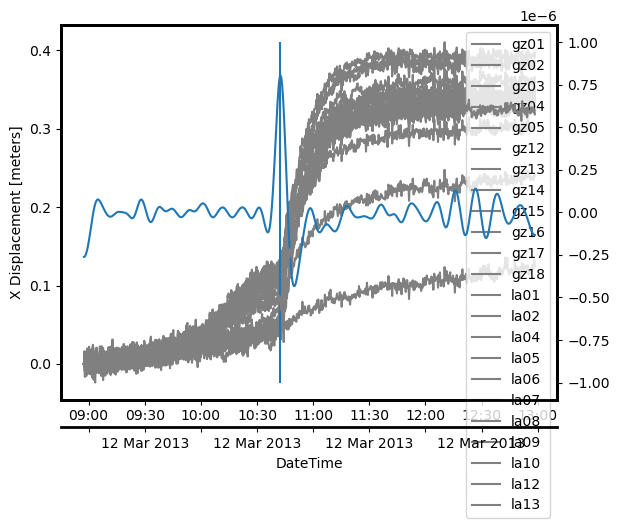

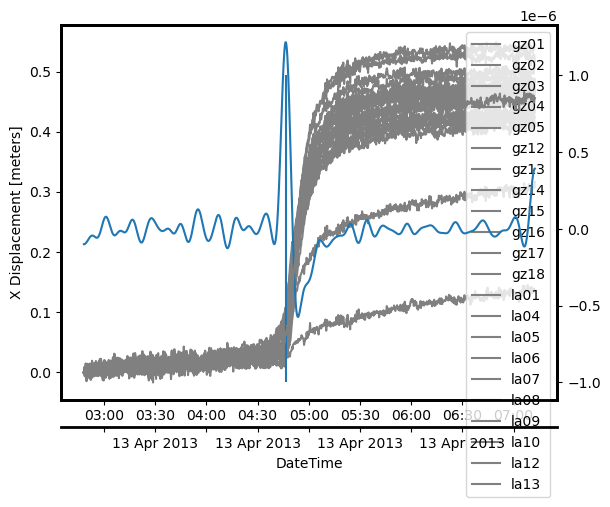

In [74]:
# Plot event, 2nd derivative, and max

# Get times of two showcase events for plotting
event1 = datetime.datetime.strptime("2013-03-12 09:00:00", "%Y-%m-%d %H:%M:%S")
event2 = datetime.datetime.strptime("2013-04-13 03:00:00", "%Y-%m-%d %H:%M:%S")
evts = [event1, event2]
df = pd.read_csv("EventStartTime.txt", sep="\t")
ev_times = df["EventStartTime"]
data["ev_time"] = [
    datetime.datetime.strptime(time, "%Y-%m-%d %H:%M:%S") for time in ev_times
]

ev_indices = np.zeros(len(evts), dtype=int)
# Find index of showcase events
for i, event in enumerate(evts):
    actual_time = min(data["ev_time"], key=lambda d: abs(d - event))
    print(actual_time)
    print(data["ev_time"].index(actual_time))
    ev_indices[i] = data["ev_time"].index(actual_time)

TO_UM = 1e6
ev_to_plot = []
for a, i in enumerate(ev_indices):
    print(data["grad2"][i])
    data["event"][i]["grad2"] = data["grad2"][i] * TO_UM
    data["event"][i]["ev_time"] = data["ev_time"][i]
    ev_to_plot.append(data["event"][i])

for i, event in zip(ev_indices, ev_to_plot):
    plot_event(i, data["event"][i])

In [76]:
# Save for GMT Plotting
for i, (event_index, event) in enumerate(zip(ev_indices, ev_to_plot)):
    time = event["time"].iloc[0][:10]
    os.mkdir(f"{i}_{time}")
    # Save x columns
    x_cols = [col for col in event if col.endswith("x")]
    for x_col in x_cols:
        nans = np.isnan(event[x_col]).any()
        if not nans:
            event[x_col] = event[x_col] - event[x_col].iloc[0]
            event.to_csv(
                f"{i}_{time}/{x_col}.txt", columns=["time", x_col], sep="\t", index=None
            )
    # Save 2nd derivative and start time
    event.to_csv(
        f"{i}_{time}/grad2.txt",
        columns=["time", "grad2", "ev_time"],
        sep="\t",
        index=None,
    )